In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Helper function to calculate analytical minimizer ---
def calculate_theta_star(x_data, y_data):
    # Add a column of ones for the intercept (theta0)
    X = np.vstack([np.ones(len(x_data)), x_data]).T
    # Analytical solution: theta_star = (X.T @ X)^-1 @ X.T @ Y
    theta_star = np.linalg.inv(X.T @ X) @ X.T @ y_data
    return theta_star, X

# ---- Dataset 1 ----
np.random.seed(45)
num_samples = 40
x1 = np.random.uniform(-20, 20, num_samples)
f_x = 100 * x1 + 1
eps = np.random.randn(num_samples)
y1 = f_x + eps
# Calculate true minimizer for Dataset 1
theta_star_1 ,X1_augmented = calculate_theta_star(x1, y1)
print(f"Dataset 1 True Minimizer (theta*): {theta_star_1}")

# ---- Dataset 2 ----
np.random.seed(45)
x2 = np.random.uniform(-1, 1, num_samples)
f_x2 = 3 * x2 + 4
eps2 = np.random.randn(num_samples)
y2 = f_x2 + eps2
# Calculate true minimizer for Dataset 2
theta_star_2 ,X2_augmented = calculate_theta_star(x2, y2)
print(f"Dataset 2 True Minimizer (theta*): {theta_star_2}")


Dataset 1 True Minimizer (theta*): [ 0.9507064  99.98412345]
Dataset 2 True Minimizer (theta*): [3.9507064  2.68246893]


In [2]:
def gradient_descent_with_momentum(x, y, theta_star, lr=0.01, beta=0.9, epochs=15, eps=0.001):
    theta0, theta1 = 0.0, 0.0  # initial values of theta parameters
    v0, v1 = 0.0, 0.0          # initial values of velocity parameters
    n = len(x)
    
    # Lists to store history for plotting and comparison
    theta0_list = [theta0]
    theta1_list = [theta1]
    v0_list = [v0]
    v1_list = [v1]
    grad0_list = []
    grad1_list = []
    mse_losses_list = []
    
    # Store theta_star components for easy access
    theta_star0, theta_star1 = theta_star[0], theta_star[1]

    for epoch in range(epochs):
        # 1. Prediction and Error
        y_pred = theta0 + theta1 * x
        error = y_pred - y

        # 2. Gradients (Full Batch)
        grad0 = (2/n) * np.sum(error)
        grad1 = (2/n) * np.sum(error * x)
        
        # Store gradients for plotting (before update)
        grad0_list.append(grad0)
        grad1_list.append(grad1)

        # 3. Update velocities (Standard Polyak Momentum: v = beta*v + grad)
        v0 = beta * v0 + grad0
        v1 = beta * v1 + grad1
        
        # Store velocities (for next step's plot)
        v0_list.append(v0)
        v1_list.append(v1)

        # 4. Parameter update (theta -= lr * v)
        theta0 -= lr * v0
        theta1 -= lr * v1
        
        # Store theta history (after update)
        theta0_list.append(theta0)
        theta1_list.append(theta1)

        # 5. Compute loss (MSE)
        mse_loss = np.mean(error**2)
        mse_losses_list.append(mse_loss)
        
        # 6. Convergence Check: ||theta_t - theta*|| < epsilon
        distance = np.sqrt((theta0 - theta_star0)**2 + (theta1 - theta_star1)**2)

        if distance < eps:
            print(f"Converged at epoch {epoch + 1} with distance {distance:.5f}")
            return theta0_list, theta1_list, v0_list, v1_list, grad0_list, grad1_list, mse_losses_list, epoch + 1

    return theta0_list, theta1_list, v0_list, v1_list, grad0_list, grad1_list, mse_losses_list, epochs

In [5]:
# --- Run for Dataset 1 ---
lr1 = 0.00005
beta1 = 0.9
epochs1 = 15
eps1 = 0.001

(
theta0_1_hist, theta1_1_hist, v0_1_hist, v1_1_hist, 
grad0_1_hist, grad1_1_hist, mse_losses_1, steps_1
) = gradient_descent_with_momentum(x1, y1, theta_star_1, lr=lr1, beta=beta1, epochs=epochs1, eps=eps1)

print(f"Dataset 1 Final Thetas: ({theta0_1_hist[-1]:.4f}, {theta1_1_hist[-1]:.4f}) after {steps_1} steps.")


# --- Run for Dataset 2 ---
lr2 = 0.01
beta2 = 0.9
epochs2 = 15
eps2 = 0.001

(
    theta0_2_hist, theta1_2_hist, v0_2_hist, v1_2_hist, 
    grad0_2_hist, grad1_2_hist, mse_losses_2, steps_2
) = gradient_descent_with_momentum(x2, y2, theta_star_2, lr=lr2, beta=beta2, epochs=epochs2, eps=eps2)

print(f"Dataset 2 Final Thetas: ({theta0_2_hist[-1]:.4f}, {theta1_2_hist[-1]:.4f}) after {steps_2} steps.")

Dataset 1 Final Thetas: (-1.0396, 78.2427) after 15 steps.
Dataset 2 Final Thetas: (4.0236, 0.8647) after 15 steps.


In [6]:
# --- Cost Function and Contour Plot Helper ---
def cost_function(X_augmented, y, theta0, theta1):
    # X_augmented is expected to be already set up as [1, x]
    m = len(y)
    # The MSE calculation used in the GD function
    J = np.dot(X_augmented, np.array([theta0, theta1])) - y
    return np.sum(J**2) / m

def plot_contour_and_path(x_data, y_data, X_augmented, theta_star, theta0_hist, theta1_hist, grad0_hist, grad1_hist, v0_hist, v1_hist, title, lr):
    # 1. Define the grid for the contour plot
    
    # Calculate appropriate range based on theta history and theta*
    all_t0 = np.array(theta0_hist + [theta_star[0]])
    all_t1 = np.array(theta1_hist + [theta_star[1]])

    t0_min, t0_max = all_t0.min() - 0.5, all_t0.max() + 0.5
    t1_min, t1_max = all_t1.min() - 0.5, all_t1.max() + 0.5
    
    # Ensure range is large enough for Dataset 1's large theta values
    if np.abs(theta_star[1]) > 50:
         t1_min, t1_max = all_t1.min() - 5, all_t1.max() + 5
         
    theta0_range = np.linspace(t0_min, t0_max, 100)
    theta1_range = np.linspace(t1_min, t1_max, 100)
    T0, T1 = np.meshgrid(theta0_range, theta1_range)
    
    # Calculate the cost function for every point on the grid
    Z = np.array([cost_function(X_augmented, y_data, t0, t1) for t0, t1 in zip(np.ravel(T0), np.ravel(T1))]).reshape(T0.shape)

    # 2. Create the plot
    plt.figure(figsize=(10, 8))
    
    # Contour lines (log scale for better visualization of minima)
    CS = plt.contour(T0, T1, Z, levels=np.logspace(np.log10(Z.min()), np.log10(Z.max()), 20), cmap='viridis')
    plt.colorbar(CS, label='MSE Loss')

    # Mark the True Minimizer (theta*)
    plt.plot(theta_star[0], theta_star[1], 'r*', markersize=10, label='True Minimizer $\\theta^*$')

    # 3. Plot the optimization path
    plt.plot(theta0_hist, theta1_hist, 'k-o', markersize=4, label='Optimization Path $\\theta_t$')
    
    # 4. Plot the vectors at each step
    # We plot N vectors for N+1 points (theta history)
    for i in range(len(grad0_hist)): 
        t0_start = theta0_hist[i]
        t1_start = theta1_hist[i]
        
        # --- Gradient Vector ---
        # The Gradient vector (grad0, grad1) points in the direction of steepest *ascent*.
        # The update direction is proportional to (-grad).
        # Scale the gradient vector for visibility. 
        grad_len_scale = lr * 0.5 # Arbitrary scaling for display purposes

        plt.quiver(t0_start, t1_start, 
                   -grad0_hist[i] * grad_len_scale, 
                   -grad1_hist[i] * grad_len_scale, 
                   color='g', scale=1, scale_units='xy', angles='xy', width=0.005, 
                   label='Scaled Negative Gradient ($-\\eta \\nabla J(\\theta)$)' if i == 0 else "")

        # --- Momentum/Velocity Vector ---
        # Momentum vector is what moves the parameter: -lr * v_t
        # Velocity v_t is v0_hist[i+1] and v1_hist[i+1] since it's calculated using the current gradient.
        v0_current = v0_hist[i+1]
        v1_current = v1_hist[i+1]
        
        # The vector shows the actual parameter update direction and magnitude: -lr*v_t
        plt.quiver(t0_start, t1_start, 
                   -lr * v0_current, 
                   -lr * v1_current, 
                   color='r', scale=1, scale_units='xy', angles='xy', width=0.005, headwidth=5, headlength=7,
                   label='Parameter Update Direction ($-\\eta v_t$)' if i == 0 else "")


    # Add a marker for the final position
    plt.plot(theta0_hist[-1], theta1_hist[-1], 'kX', markersize=8, label='Final $\\theta$')

    # Final plot setup
    plt.title(title)
    plt.xlabel('$\\theta_0$ (Intercept)')
    plt.ylabel('$\\theta_1$ (Slope)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

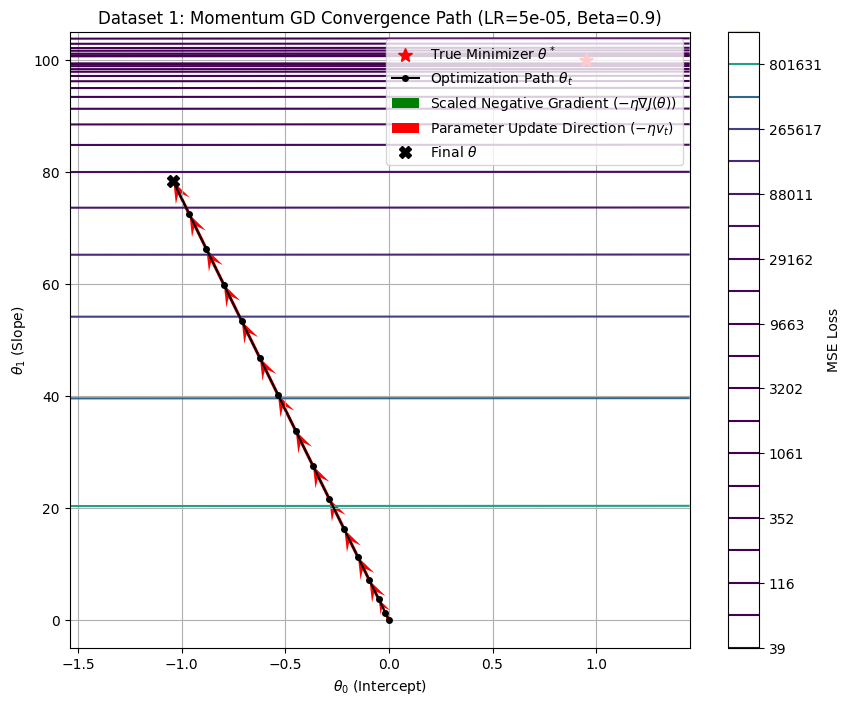

In [9]:
# --- Contour Plot for Dataset 1 ---
plot_contour_and_path(
    x1, y1, X1_augmented, theta_star_1, 
    theta0_1_hist, theta1_1_hist, 
    grad0_1_hist, grad1_1_hist, 
    v0_1_hist, v1_1_hist, 
    f'Dataset 1: Momentum GD Convergence Path (LR={lr1}, Beta={beta1})', 
    lr1
)

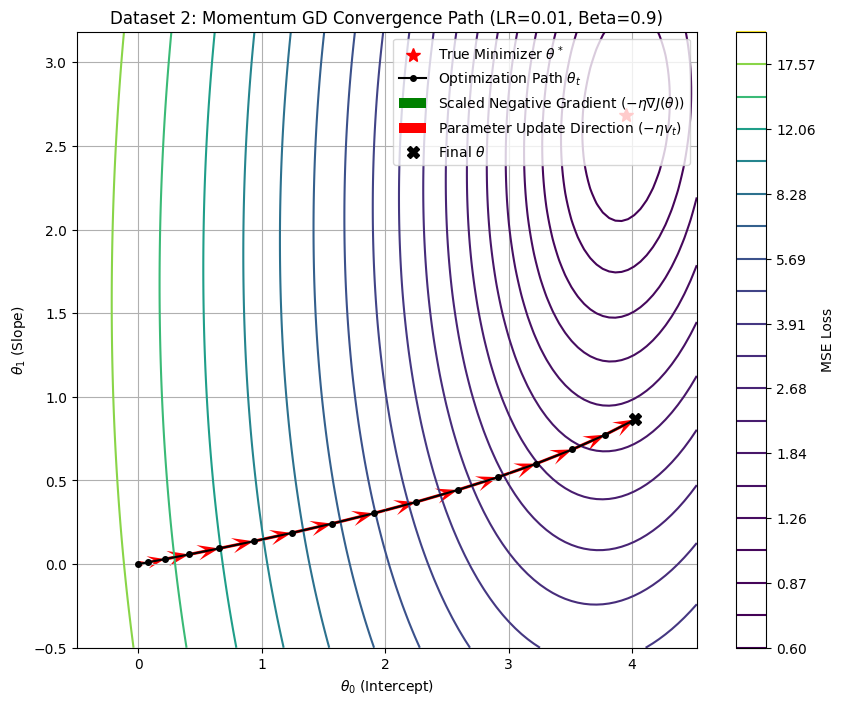

In [10]:
# --- Contour Plot for Dataset 2 ---
# The cost function and plot_contour_and_path function are defined in the previous cell.
plot_contour_and_path(
    x2, y2, X2_augmented, theta_star_2, 
    theta0_2_hist, theta1_2_hist, 
    grad0_2_hist, grad1_2_hist, 
    v0_2_hist, v1_2_hist, 
    f'Dataset 2: Momentum GD Convergence Path (LR={lr2}, Beta={beta2})', 
    lr2
)

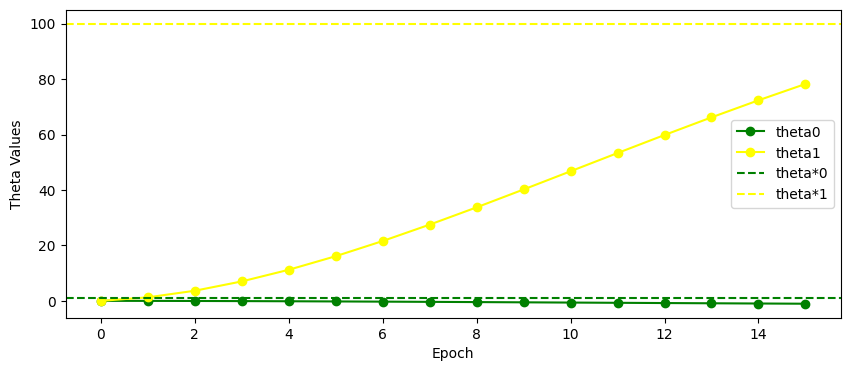

In [11]:
#plotting theta values of Dataset-1
plt.figure(figsize=(10,4))

plt.plot(theta0_1_hist, marker='o', label='theta0', color = 'green')
plt.plot(theta1_1_hist, marker='o', label='theta1', color = 'yellow')

# Plot theta* reference lines
plt.axhline(theta_star_1[0], color='green', linestyle='--', label='theta*0')
plt.axhline(theta_star_1[1], color='yellow', linestyle='--', label='theta*1')

plt.xlabel("Epoch")
plt.ylabel("Theta Values")

plt.legend()
plt.show()

In [23]:
import numpy as np
from collections import defaultdict

# --- Full-Batch GD with Momentum (FGD-M) ---
def momentum_gd_for_comparison(x, y, theta_star, lr=0.01, beta=0.9, epochs=50000, eps=0.001): # Increased Epochs
    """
    Implements Full-Batch Gradient Descent with Momentum (FGD-M).
    Returns the number of epochs to reach the epsilon-neighborhood of theta*.
    """
    theta0, theta1 = 0.0, 0.0
    v0, v1 = 0.0, 0.0
    n = len(x)
    theta_star0, theta_star1 = theta_star[0], theta_star[1]

    for epoch in range(epochs):
        # 1. Full-Batch Gradient Calculation
        y_pred = theta0 + theta1 * x
        error = y_pred - y
        grad0 = (2/n) * np.sum(error)
        grad1 = (2/n) * np.sum(error * x)

        # 2. Update velocities (Polyak Momentum: v = beta*v + grad)
        v0 = beta * v0 + grad0
        v1 = beta * v1 + grad1

        # 3. Parameter update
        theta0 -= lr * v0
        theta1 -= lr * v1
        
        # 4. Convergence Check: ||theta_t - theta*|| < epsilon
        distance = np.sqrt((theta0 - theta_star0)**2 + (theta1 - theta_star1)**2)

        if distance < eps:
            return epoch + 1 # Returns epochs

    return epochs # Returns max epochs if not converged

# --- Stochastic Gradient Descent with Momentum (SGD-M) ---
def sgd_momentum_for_comparison(x, y, theta_star, lr=0.001, beta=0.9, epochs=50000, eps=0.001): # Increased Epochs
    """
    Implements Stochastic Gradient Descent with Momentum (SGD-M).
    Returns the total number of parameter updates to reach the epsilon-neighborhood of theta*.
    """
    theta0, theta1 = 0.0, 0.0
    v0, v1 = 0.0, 0.0
    n = len(x)
    theta_star0, theta_star1 = theta_star[0], theta_star[1]
    steps = 0
    
    for epoch in range(epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        
        for i in indices:
            # Single Sample Gradient Calculation
            xi, yi = x[i], y[i]
            y_pred_i = theta0 + theta1 * xi
            error_i = y_pred_i - yi
            
            grad0 = 2 * error_i
            grad1 = 2 * error_i * xi
            
            # Momentum Update (Polyak: v = beta*v + grad)
            v0 = beta * v0 + grad0
            v1 = beta * v1 + grad1
            
            # Parameter Update (theta -= lr * v)
            theta0 -= lr * v0
            theta1 -= lr * v1
            steps += 1
            
            # Convergence Check after every update
            distance = np.sqrt((theta0 - theta_star0)**2 + (theta1 - theta_star1)**2)
            if distance < eps:
                return steps # Returns total updates

    return steps # Returns total updates (max updates)


# --- Comparison Parameters ---
N_TRIALS = 20
EPSILON = 0.001
MAX_EPOCHS = 50000 # Increased MAX_EPOCHS to ensure convergence

# Unified Hyperparameters
UNIFIED_LR = 0.00005
UNIFIED_BETA = 0.9


# --- Execution and Results Storage ---
datasets = {
    'Dataset 1': {'x': x1, 'y': y1, 'theta_star': theta_star_1, 'results': defaultdict(list)},
    'Dataset 2': {'x': x2, 'y': y2, 'theta_star': theta_star_2, 'results': defaultdict(list)},
}

for name, data in datasets.items():
    x, y, theta_star = data['x'], data['y'], data['theta_star']
    
    print(f"--- Running Momentum Variants on {name} for {N_TRIALS} trials (LR={UNIFIED_LR}, Beta={UNIFIED_BETA}) ---")

    for _ in range(N_TRIALS):
        # Full-Batch GD with Momentum (FGD-M)
        steps_fgd_m = momentum_gd_for_comparison(
            x, y, theta_star, lr=UNIFIED_LR, beta=UNIFIED_BETA, epochs=MAX_EPOCHS, eps=EPSILON
        )
        data['results']['FGD-M'].append(steps_fgd_m)
        
        # Stochastic GD with Momentum (SGD-M)
        steps_sgd_m = sgd_momentum_for_comparison(
            x, y, theta_star, lr=UNIFIED_LR, beta=UNIFIED_BETA, epochs=MAX_EPOCHS, eps=EPSILON
        )
        data['results']['SGD-M'].append(steps_sgd_m)


# --- Calculate and Print Averages (FIXED) ---

print("\n" + "="*70)
print(f"Momentum GD Convergence Statistics (Unified LR: {UNIFIED_LR}, Beta: {UNIFIED_BETA})")
print("="*70)

print(f"{'Method':<15} | {'Dataset 1 (Avg Epochs/Updates)':<30} | {'Dataset 2 (Avg Epochs/Updates)':<30}")
print("-" * 70)

for name, data in datasets.items():
    
    # Full-Batch Momentum (FGD-M) - Calculate Averages and STD for Epochs
    converged_fgd_m_steps = [s for s in data['results']['FGD-M'] if s < MAX_EPOCHS]
    if len(converged_fgd_m_steps) > 0:
        avg_fgd_m = np.mean(converged_fgd_m_steps)
        avg_fgd_m_std = np.std(converged_fgd_m_steps)
    else:
        avg_fgd_m = MAX_EPOCHS
        avg_fgd_m_std = 0
    
    # Stochastic Momentum (SGD-M) - Calculate Averages and STD for Total Updates
    max_updates = len(data['results']['SGD-M']) * MAX_EPOCHS
    converged_sgd_m_steps = [s for s in data['results']['SGD-M'] if s < max_updates]
    if len(converged_sgd_m_steps) > 0:
        avg_sgd_m = np.mean(converged_sgd_m_steps)
        avg_sgd_m_std = np.std(converged_sgd_m_steps)
    else:
        avg_sgd_m = max_updates
        avg_sgd_m_std = 0
        
    # Store results using LaTeX format for display: AVG +/- STD
    data['Avg_FGD-M'] = f"{avg_fgd_m:.1f} ± {avg_fgd_m_std:.1f} epochs"
    data['Avg_SGD-M'] = f"{avg_sgd_m:.1f} ± {avg_sgd_m_std:.1f} updates"
    
# --- Display Final Table ---
print(f"{'FGD-M':<15} | {datasets['Dataset 1']['Avg_FGD-M']:<38} | {datasets['Dataset 2']['Avg_FGD-M']:<38}")
print(f"{'SGD-M':<15} | {datasets['Dataset 1']['Avg_SGD-M']:<38} | {datasets['Dataset 2']['Avg_SGD-M']:<38}")

print("="*85)

--- Running Momentum Variants on Dataset 1 for 20 trials (LR=5e-05, Beta=0.9) ---
--- Running Momentum Variants on Dataset 2 for 20 trials (LR=5e-05, Beta=0.9) ---

Momentum GD Convergence Statistics (Unified LR: 5e-05, Beta: 0.9)
Method          | Dataset 1 (Avg Epochs/Updates) | Dataset 2 (Avg Epochs/Updates)
----------------------------------------------------------------------
FGD-M           | 7858.0 ± 0.0 epochs                    | 26289.0 ± 0.0 epochs                  
SGD-M           | 6353.9 ± 1082.7 updates                | 23302.0 ± 528.8 updates               
